# Adapting Problem Session 8 to our DST project


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
sns.set_style("whitegrid")


In [3]:
finance = pd.read_csv('finance1970-2018.csv')

In [4]:
finance.sample(4)


,Unnamed: 0,index,ticker,open,close,adj_close,low,high,volume,date,date_time
376080,376080,20519327,COLB,25.820000,25.730000,20.175480,25.629999,25.889999,6500,2005-10-07,2005-10-07
1694986,1694986,1709532,WNEB,6.506409,6.628309,4.358642,6.506409,6.649642,31800,2004-08-24,2004-08-24
65929,65929,18247853,ASRV,4.166667,4.166667,1.230702,4.000000,4.166667,44400,1989-06-29,1989-06-29
1618580,1618580,3758137,UFCS,20.059999,20.230000,16.175444,19.719999,20.420000,51000,2011-12-05,2011-12-05


In [6]:
finance_ticker = pd.read_csv('finance_stocks.csv')

In [8]:
finance_ticker.sample(4)

,Unnamed: 0,ticker,exchange,name,sector,industry
728,3650,BMO,NYSE,BANK OF MONTREAL,FINANCE,COMMERCIAL BANKS
380,1786,LCAHW,NASDAQ,"LANDCADIA HOLDINGS, INC.",FINANCE,BUSINESS SERVICES
526,2451,PRAA,NASDAQ,"PRA GROUP, INC.",FINANCE,FINANCE: CONSUMER SERVICES
855,4901,JLL,NYSE,JONES LANG LASALLE INCORPORATED,FINANCE,REAL ESTATE


In [5]:
def get_stocks(df, df2, stock_code):
    # get prices for a particular stock; this function takes in two data frames where one has the prices
    # the other has the codes
    print(df2[df2['ticker']==stock_code])
    return df[df['ticker']==stock_code].reset_index()

In [9]:
df_WFC=get_stocks(finance, finance_ticker, 'WFC')

      Unnamed: 0 ticker exchange                   name   sector     industry
1012        6350    WFC     NYSE  WELLS FARGO & COMPANY  FINANCE  MAJOR BANKS


In [10]:
df_WFC

,level_0,Unnamed: 0,index,ticker,open,close,adj_close,low,high,volume,date,date_time
0,3086663,3086663,17065605,WFC,0.880208,0.880208,0.002267,0.880208,0.882812,249600,1972-06-01,1972-06-01
1,3086664,3086664,17065615,WFC,0.882812,0.882812,0.002274,0.882812,0.890625,172800,1972-06-02,1972-06-02
2,3086665,3086665,17065628,WFC,0.882812,0.895833,0.002308,0.880208,0.895833,302400,1972-06-05,1972-06-05
3,3086666,3086666,17065639,WFC,0.895833,0.895833,0.002308,0.893229,0.911458,196800,1972-06-06,1972-06-06
4,3086667,3086667,17065649,WFC,0.895833,0.888021,0.002287,0.888021,0.895833,48000,1972-06-07,1972-06-07
...,...,...,...,...,...,...,...,...,...,...,...,...
11650,3098313,3098313,17189905,WFC,58.810001,59.029999,59.029999,58.669998,59.209999,11403400,2018-08-20,2018-08-20
11651,3098314,3098314,17189921,WFC,59.000000,58.959999,58.959999,58.939999,59.529999,17943500,2018-08-21,2018-08-21
11652,3098315,3098315,17189927,WFC,59.040001,59.169998,59.169998,58.830002,59.500000,20829600,2018-08-22,2018-08-22
11653,3098316,3098316,17189943,WFC,59.000000,58.619999,58.619999,58.570000,59.049999,19655600,2018-08-23,2018-08-23


In [37]:
def custom_time_indexing(df, date_column):
    """
    Function to reindex a DataFrame with a custom index that reflects gaps in a time series,
    while keeping the original date column for plotting, without modifying the original DataFrame.

    Parameters:
    df (pd.DataFrame): Input DataFrame.
    date_column (str): Name of the column containing datetime objects.

    Returns:
    pd.DataFrame: A new DataFrame with the custom index reflecting date gaps,
                  while retaining the original dates in a new column.
    list: A list of the original date labels corresponding to valid data rows.
    """
    # Work on a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Ensure the date_column is of datetime type
    df_copy[date_column] = pd.to_datetime(df_copy[date_column])

    # Set the date column as the index
    df_copy.set_index(date_column, inplace=True)

    # Generate the full date range (including missing dates)
    full_range = pd.date_range(start=df_copy.index.min(), end=df_copy.index.max())

    # Reindex the DataFrame to include the full range of dates
    df_reindexed = df_copy.reindex(full_range)

    # Create a custom index that increments by 1, but jumps when there are missing dates
    custom_index = []
    current_index = 1

    for i in range(len(df_reindexed)):
        if i == 0:
            custom_index.append(current_index)
        else:
            # Check if the current date is consecutive to the previous one
            if df_reindexed.index[i] - df_reindexed.index[i-1] > timedelta(days=1):
                # Increase the custom index by the actual day difference
                current_index += (df_reindexed.index[i] - df_reindexed.index[i-1]).days
            else:
                current_index += 1
            custom_index.append(current_index)

    # Assign the custom index to the DataFrame
    df_reindexed['custom_index'] = custom_index

    # Drop the rows where there are missing values
    df_final = df_reindexed.dropna()

    # Add the original date index as a new column and make it a datetime object
    df_final['date_time'] = df_final.index
    df_final['date_time']=df_final['date_time'].apply(lambda day: day.date())

    # Set the new custom index
    df_final.set_index('custom_index', inplace=True)

    # Return the final DataFrame and the valid original dates
    return df_final, df_final['date_time']


In [38]:
df_WFC_reindex = custom_time_indexing(df_WFC,'date_time')[0]

/var/folders/4l/xdk1tfxx7jbd3zsydcl3t4vh0000gn/T/ipykernel_96401/3743447978.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['date_time'] = df_final.index
/var/folders/4l/xdk1tfxx7jbd3zsydcl3t4vh0000gn/T/ipykernel_96401/3743447978.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['date_time']=df_final['date_time'].apply(lambda day: day.date())


In [58]:
metrics = list(df_WFC.columns)

In [59]:
metrics = metrics[4:10]
metrics

['open', 'close', 'adj_close', 'low', 'high', 'volume']

We only want weekends and then to have a column that says whether it's a DST weekend

In [26]:
weekends=pd.read_csv('weekends1970_2018.csv')

In [32]:
weekends.head()

,Unnamed: 0,Fridays,Mondays
0,0,1970-01-02,1970-01-05
1,1,1970-01-09,1970-01-12
2,2,1970-01-16,1970-01-19
3,3,1970-01-23,1970-01-26
4,4,1970-01-30,1970-02-02


In [33]:
# ANOTHER VERY USEFUL function for getting the stock prices of all weekends; need dataframe and metrics

def get_fri_mon_prices(df,fri_metric,mon_metric):
    # metric1,2 = high, low, open, close, volume, etc.
    mon_fri_prices=[]

    for fri,mon in zip(weekends['Fridays'].values, weekends['Mondays'].values): # I stored these as strings
        fri = datetime.strptime(fri, '%Y-%m-%d').date()
        mon = datetime.strptime(mon, '%Y-%m-%d').date()

        if (fri in df['date_time'].values) and (mon in df['date_time'].values):
            print('Have data for both:',fri, mon)
            
            fri_price=df.loc[df['date_time'] == fri, fri_metric].values[0]
            mon_price=df.loc[df['date_time'] == mon, mon_metric].values[0]
            
            mon_fri_prices.append((fri.strftime('%Y-%m-%d'),mon.strftime('%Y-%m-%d'),fri_price,mon_price))

        else:
            print('Missing data for at least one of:', fri, mon) 
    return mon_fri_prices 

In [28]:
# for suppressing what a function prints out as part of debugging
import contextlib
import io

In [40]:
with contextlib.redirect_stdout(io.StringIO()):
    WFC_open= get_fri_mon_prices(df_WFC_reindex,'open','open')

In [44]:
df_WFC_open = pd.DataFrame(WFC_open)

In [47]:
df_WFC_open.columns = ['fri','mon','fri_open','mon_open']

In [49]:
# see just the info
df_WFC_open[['fri_open','mon_open']]

,fri_open,mon_open
0,0.882812,0.882812
1,0.890625,0.895833
2,0.893229,0.895833
3,0.906250,0.914062
4,0.947917,0.958333
...,...,...
2122,56.070000,56.389999
2123,58.380001,58.830002
2124,58.060001,58.580002
2125,57.380001,57.660000


In [84]:
WFC = pd.DataFrame()

for metric in metrics:
    fri_label = 'fri_'+ metric
    mon_label = 'mon_'+ metric
    with contextlib.redirect_stdout(io.StringIO()):
        df_metric = pd.DataFrame(get_fri_mon_prices(df_WFC_reindex,metric,metric))[[2,3]] # drop the dates
    df_metric.columns = [fri_label, mon_label]
    WFC=pd.concat([WFC,df_metric],axis=1)

In [85]:
with contextlib.redirect_stdout(io.StringIO()):
    dates = pd.DataFrame(get_fri_mon_prices(df_WFC_reindex,'open','open'))[[0,1]]
dates.columns = ['fri','mon']
WFC=pd.concat([dates,WFC],axis=1)

In [86]:
WFC.head()

,fri,mon,fri_open,mon_open,fri_close,mon_close,fri_adj_close,mon_adj_close,fri_low,mon_low,fri_high,mon_high,fri_volume,mon_volume
0,1972-06-02,1972-06-05,0.882812,0.882812,0.882812,0.895833,0.002274,0.002308,0.882812,0.880208,0.890625,0.895833,172800.0,302400.0
1,1972-06-09,1972-06-12,0.890625,0.895833,0.890625,0.901042,0.002294,0.002321,0.885417,0.895833,0.895833,0.901042,43200.0,24000.0
2,1972-06-16,1972-06-19,0.893229,0.895833,0.901042,0.893229,0.002321,0.002301,0.893229,0.893229,0.901042,0.895833,48000.0,91200.0
3,1972-06-23,1972-06-26,0.906250,0.914062,0.914062,0.916667,0.002355,0.002361,0.906250,0.906250,0.914062,0.916667,96000.0,62400.0
4,1972-06-30,1972-07-03,0.947917,0.958333,0.958333,0.973958,0.002469,0.002509,0.947917,0.958333,0.958333,0.973958,72000.0,57600.0


In [87]:
dst_dates = pd.read_csv('DST_fri_mon.csv')

In [97]:
dst_fri_dates = list(dst_dates['fall_fri_before'])+list(dst_dates['spring_fri_before'])

In [99]:
len(dst_fri_dates)

110

In [100]:
# this gives a 1 or 0 for whether a date is DST or not

WFC['y'] = WFC['fri'].isin(dst_fri_dates).astype(int)

In [104]:
WFC.head()

,fri,mon,fri_open,mon_open,fri_close,mon_close,fri_adj_close,mon_adj_close,fri_low,mon_low,fri_high,mon_high,fri_volume,mon_volume,y
0,1972-06-02,1972-06-05,0.882812,0.882812,0.882812,0.895833,0.002274,0.002308,0.882812,0.880208,0.890625,0.895833,172800.0,302400.0,0
1,1972-06-09,1972-06-12,0.890625,0.895833,0.890625,0.901042,0.002294,0.002321,0.885417,0.895833,0.895833,0.901042,43200.0,24000.0,0
2,1972-06-16,1972-06-19,0.893229,0.895833,0.901042,0.893229,0.002321,0.002301,0.893229,0.893229,0.901042,0.895833,48000.0,91200.0,0
3,1972-06-23,1972-06-26,0.906250,0.914062,0.914062,0.916667,0.002355,0.002361,0.906250,0.906250,0.914062,0.916667,96000.0,62400.0,0
4,1972-06-30,1972-07-03,0.947917,0.958333,0.958333,0.973958,0.002469,0.002509,0.947917,0.958333,0.958333,0.973958,72000.0,57600.0,0


#### 3. Train test split

##### a.

Look at how the data is split between the two classes. Does this appear to be imbalanced data? <i>Recall that we say data is imbalanced if one of the classes has a very small presence in the data set.

In [105]:
WFC['y'].value_counts(normalize=True) # see the proportion of each group

y
0    0.958627
1    0.041373
Name: proportion, dtype: float64

##### b.

Make a train test split, set aside $10\%$ of the data as the test set (note that we are using $10\%$ because this was the split they used in the paper).

In [106]:
from sklearn.model_selection import train_test_split

In [107]:
# we want to split the training and test data in a way that respects the stratification of DST and nonDST
WFC_train, WFC_test = train_test_split(WFC,test_size=0.1,stratify=WFC['y'])


#### 4. Exploratory data analysis (EDA)

Before building any models you will do some EDA.

##### a. 

One way to try and identify key features for classification algorithms is to plot histograms of the feature values for each of the classes.

Below is an example of such a histogram for the `Area` column made using `plt.hist`.

In [108]:
WFC_train.columns

Index(['fri', 'mon', 'fri_open', 'mon_open', 'fri_close', 'mon_close',
       'fri_adj_close', 'mon_adj_close', 'fri_low', 'mon_low', 'fri_high',
       'mon_high', 'fri_volume', 'mon_volume', 'y'],
      dtype='object')

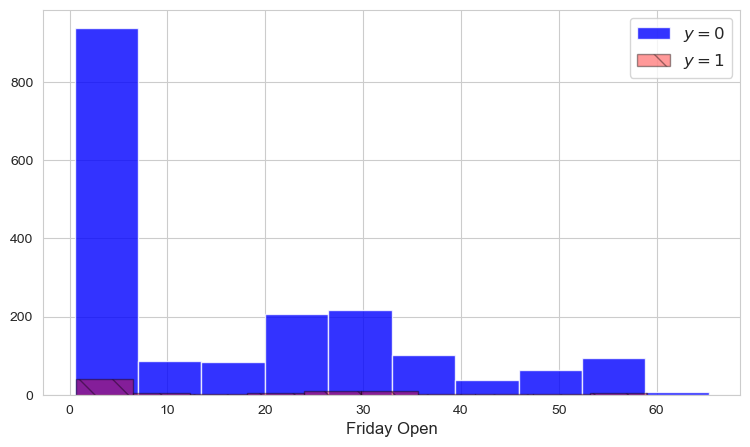

In [110]:
plt.figure(figsize=(9,5))


plt.hist(WFC_train.loc[WFC_train.y==0]['fri_open'].values,
            color='blue',
            alpha=.8,
            label="$y=0$")

plt.hist(WFC_train.loc[WFC_train.y==1]['fri_open'].values,
            color='red',
            alpha=.4,
            hatch = '\\',
            edgecolor='black',
            label="$y=1$")

plt.xlabel("Friday Open", fontsize=12)
plt.legend(fontsize=12)

plt.show()

In [115]:
metrics = list(WFC.columns)

In [119]:
metrics[2:14]

['fri_open',
 'mon_open',
 'fri_close',
 'mon_close',
 'fri_adj_close',
 'mon_adj_close',
 'fri_low',
 'mon_low',
 'fri_high',
 'mon_high',
 'fri_volume',
 'mon_volume']

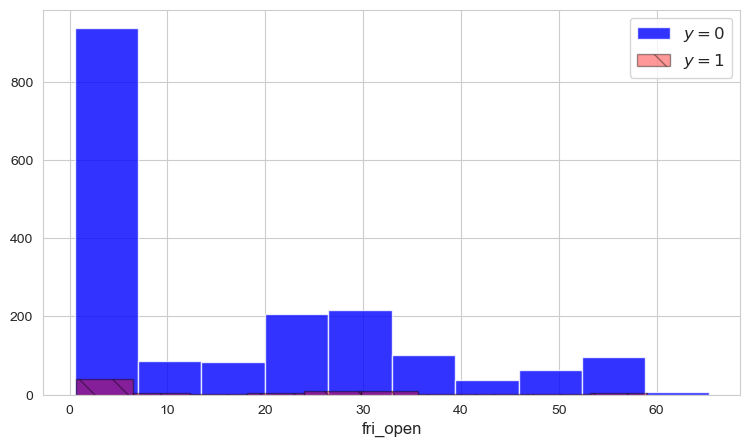

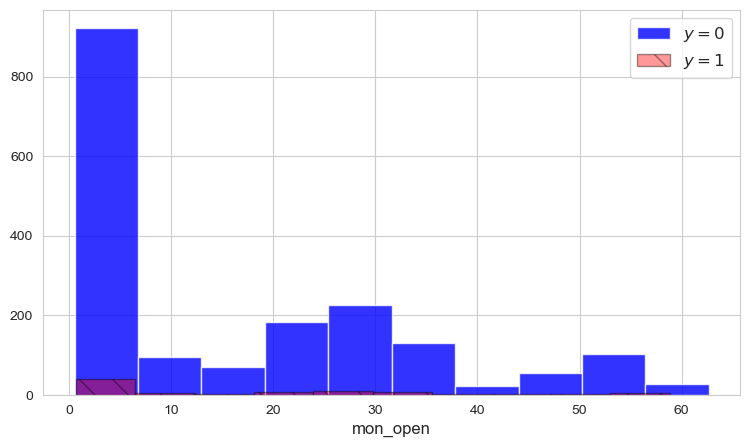

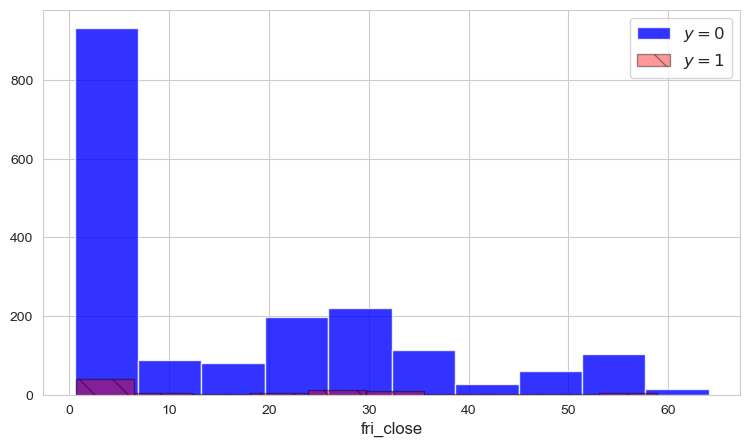

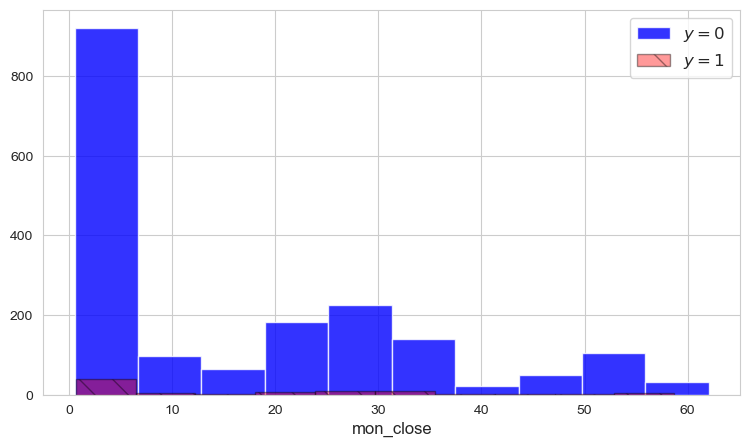

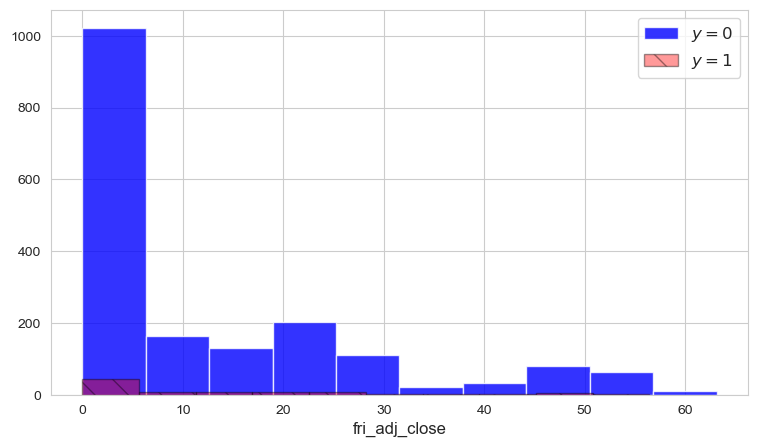

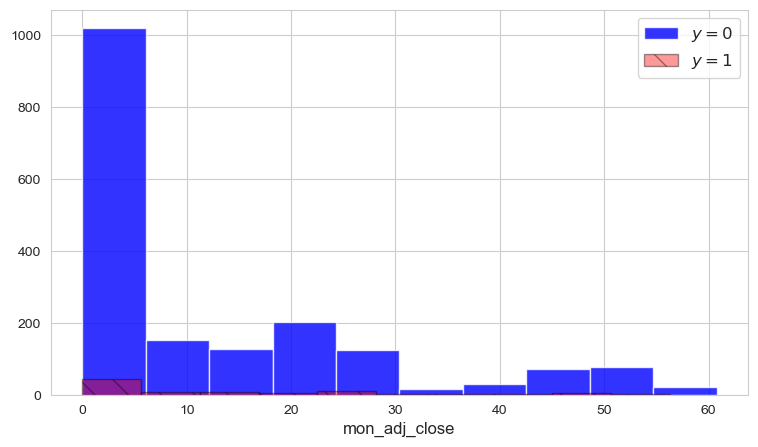

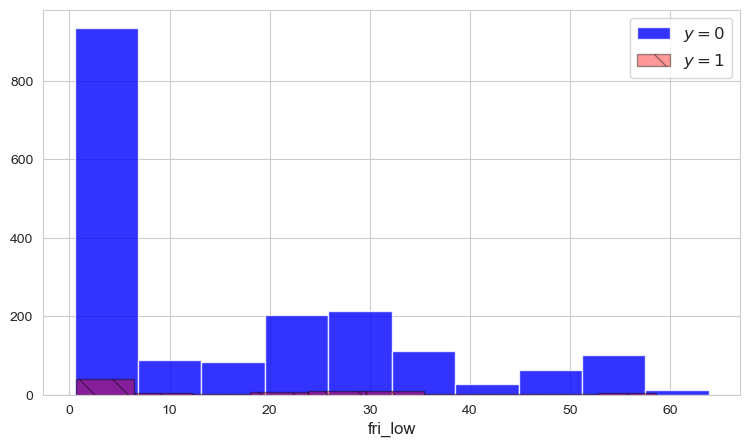

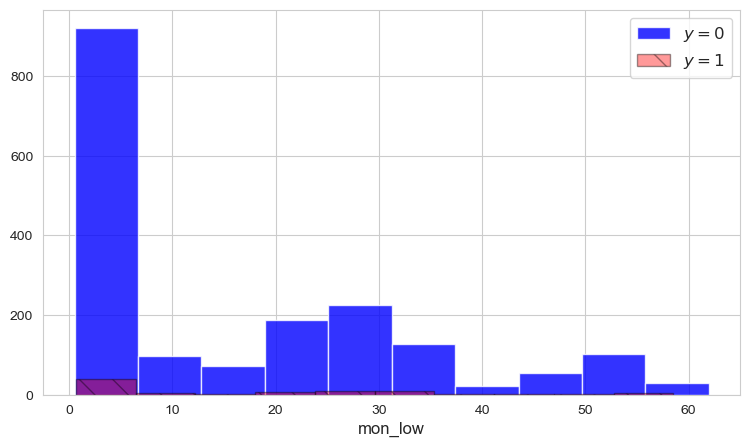

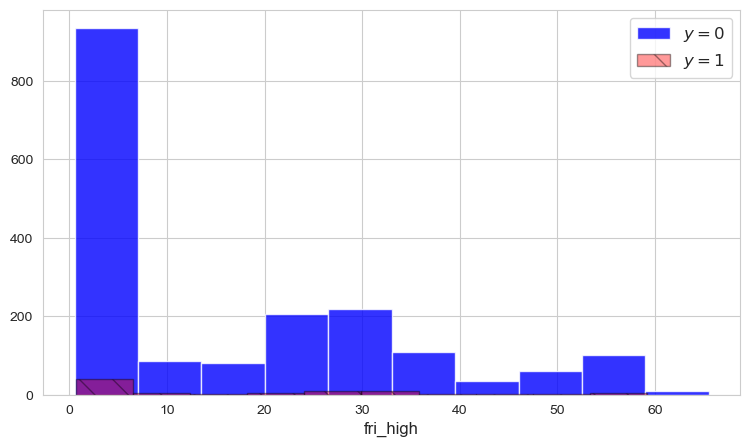

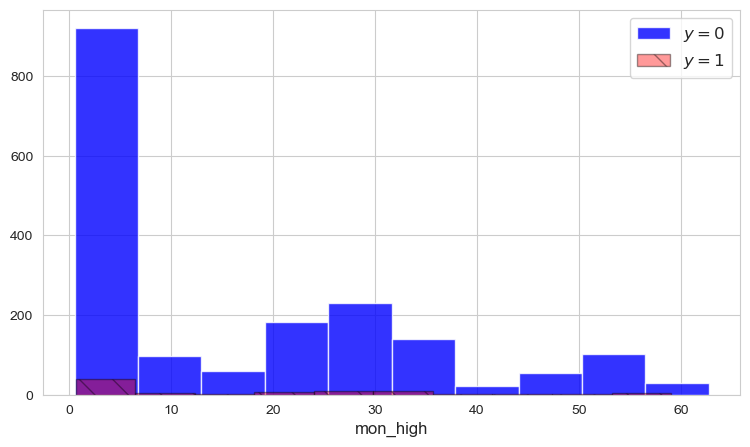

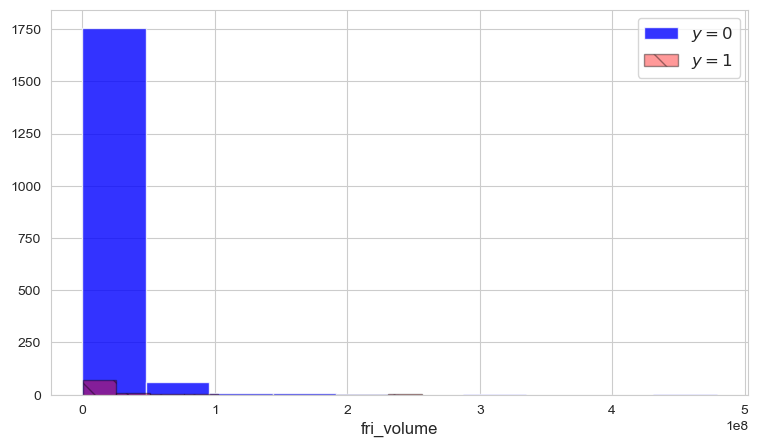

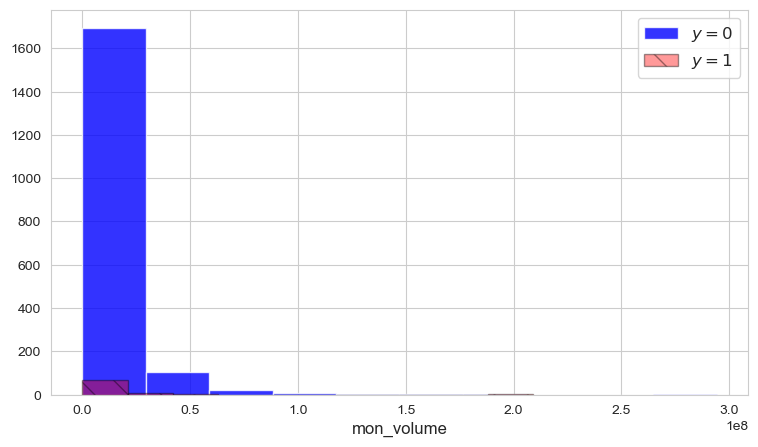

In [121]:
for metric in metrics[2:14]:
    plt.figure(figsize=(9,5))

    plt.hist(WFC_train.loc[WFC_train.y==0][metric].values,
                color='blue',
                alpha=.8,
                label="$y=0$")

    plt.hist(WFC_train.loc[WFC_train.y==1][metric].values,
                color='red',
                alpha=.4,
                hatch = '\\',
                edgecolor='black',
                label="$y=1$")

    plt.xlabel(metric, fontsize=12)
    plt.legend(fontsize=12)

    plt.show()

We make a `seaborn` `pairplot` using the features as the arguments for `x_vars` and `y_vars`. Use `y` as the argument to `hue`.

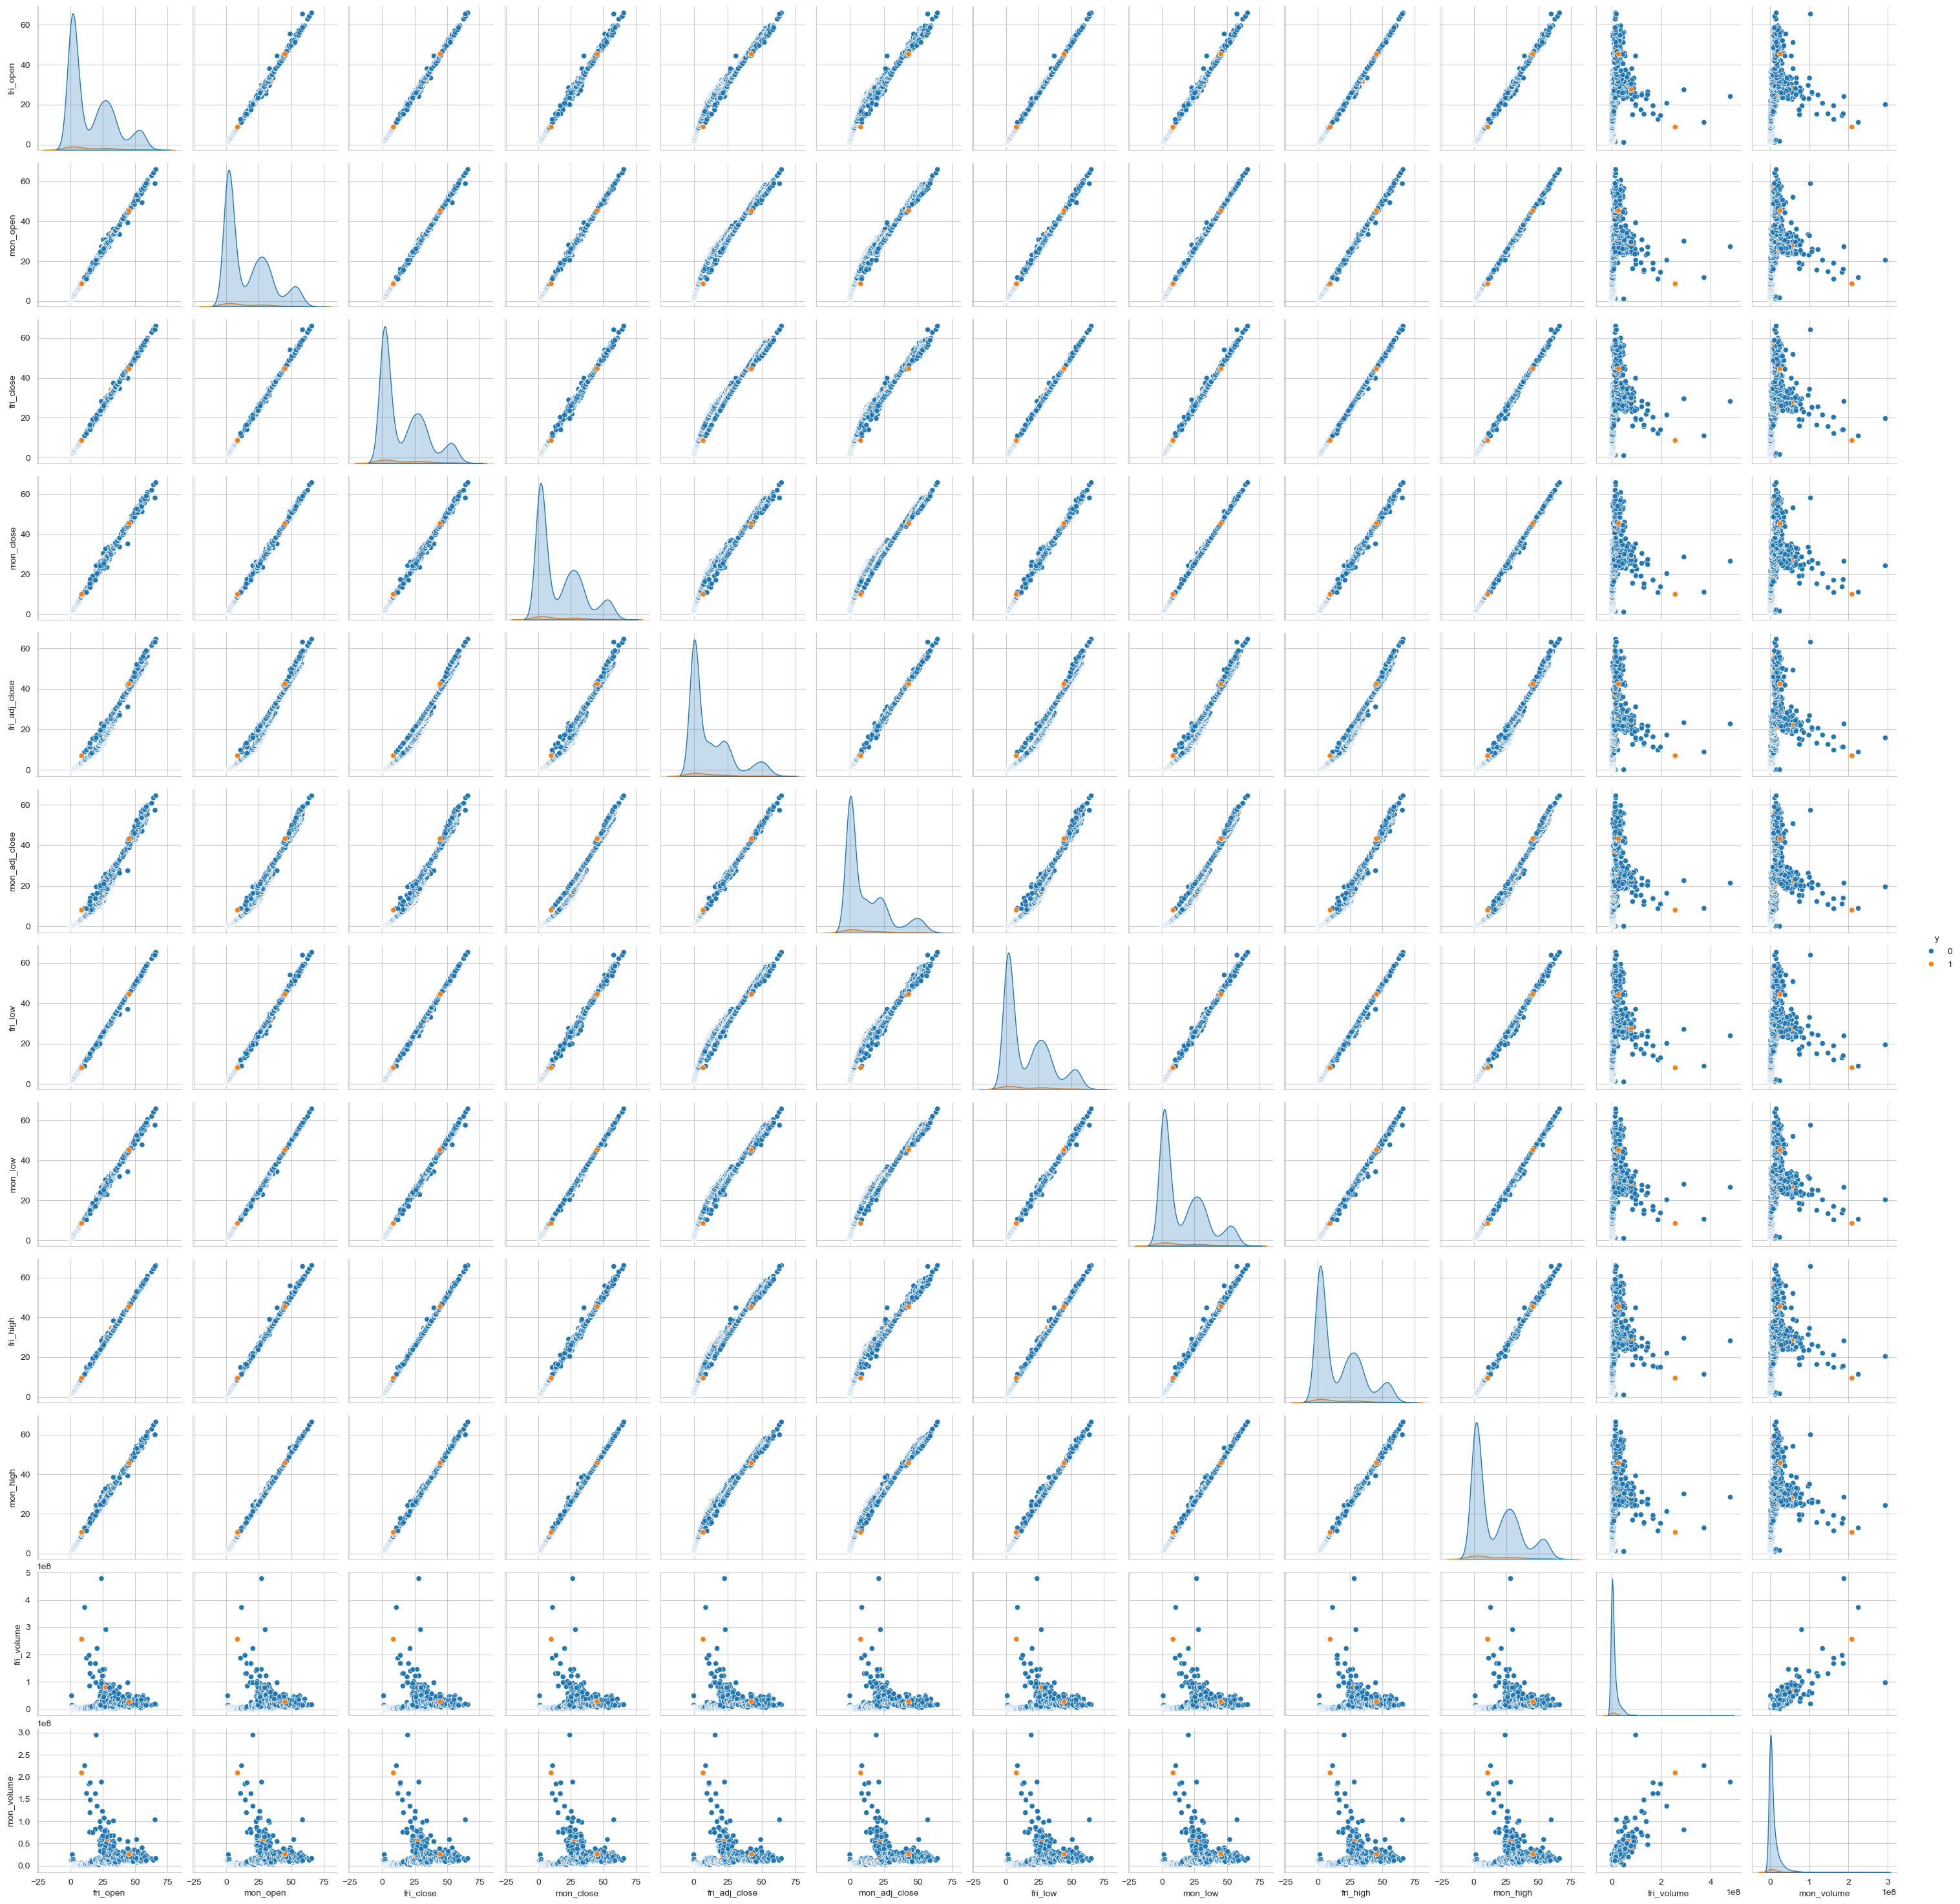

In [122]:
## Fill in the missing code
sns.pairplot(data = WFC,
                x_vars = metrics[2:14],
                y_vars = metrics[2:14],
                hue = 'y')

plt.show()

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

In [124]:
## Make your kfold object
n_splits = 5

kfold = KFold(n_splits=n_splits)

In [125]:
metrics = metrics[2:14]

In [126]:
metrics

['fri_open',
 'mon_open',
 'fri_close',
 'mon_close',
 'fri_adj_close',
 'mon_adj_close',
 'fri_low',
 'mon_low',
 'fri_high',
 'mon_high',
 'fri_volume',
 'mon_volume']

In [127]:
## Make your array of zeros to hold the accuracies
log_reg_accs = np.zeros((n_splits,len(metrics)))

## Loop through the cv splits
i = 0
for train_index, test_index in kfold.split(WFC_train):
    ## get the training and holdout sets
    WFC_tt = WFC_train.iloc[train_index]
    WFC_ho = WFC_train.iloc[test_index]
    
    ## loop through your features
    j = 0
    for metric in metrics:
        ## Define the model
        log_reg = LogisticRegression()
        
        ## fit the model
        log_reg.fit(WFC_tt[[metric]],WFC_tt['y'])
        
        ## Make the prediction
        pred = log_reg.predict(WFC_ho[[metric]])
        
        ## Record the accuracy on the holdout set
        log_reg_accs[i,j] = accuracy_score(pred,WFC_ho['y'])
        
        j = j + 1
    i = i + 1

In [128]:
log_reg_accs

array([[0.95300261, 0.95300261, 0.95300261, 0.95300261, 0.95300261,
        0.95300261, 0.95300261, 0.95300261, 0.95300261, 0.95300261,
        0.95300261, 0.95300261],
       [0.95039164, 0.95039164, 0.95039164, 0.95039164, 0.95039164,
        0.95039164, 0.95039164, 0.95039164, 0.95039164, 0.95039164,
        0.95039164, 0.95039164],
       [0.96866841, 0.96866841, 0.96866841, 0.96866841, 0.96866841,
        0.96866841, 0.96866841, 0.96866841, 0.96866841, 0.96866841,
        0.96866841, 0.96866841],
       [0.95822454, 0.95822454, 0.95822454, 0.95822454, 0.95822454,
        0.95822454, 0.95822454, 0.95822454, 0.95822454, 0.95822454,
        0.95822454, 0.95822454],
       [0.96335079, 0.96335079, 0.96335079, 0.96335079, 0.96335079,
        0.96335079, 0.96335079, 0.96335079, 0.96335079, 0.96335079,
        0.96335079, 0.96335079]])

Compare these models to the logistic regression model that incorporates all of the features.

In [129]:
i = 0

full_log_reg_acc=np.zeros(n_splits)

for train_index, test_index in kfold.split(WFC_train):
    WFC_tt = WFC_train.iloc[train_index]
    WFC_ho = WFC_train.iloc[test_index]
    
    ## Define the model, fit the model, then record the accuracies
    WFC_tt = WFC_train.iloc[train_index]
    WFC_ho = WFC_train.iloc[test_index]
    
    ## loop through your features
    
    log_reg = LogisticRegression(penalty=None,max_iter=1000)
    
    ## fit the model
    log_reg.fit(WFC_tt[metrics],WFC_tt['y'])
    
    ## Make the prediction
    pred = log_reg.predict(WFC_ho[metrics])
    
    ## Record the accuracy on the holdout set
    full_log_reg_acc[i] = accuracy_score(pred,WFC_ho['y'])
    
    i = i + 1

In [131]:
# accuracy
full_log_reg_acc

array([0.95300261, 0.95039164, 0.96083551, 0.95822454, 0.96335079])

In [132]:
WFC['y'].value_counts(normalize=True) # see the proportion of each group

y
0    0.958627
1    0.041373
Name: proportion, dtype: float64

The model might just be guessing that all of the weekends are non-DST and since most are non-DST, it's getting pretty accurate results.


In [133]:
# Import the model classes.  Remember that we should always scale our features before using kNN
# So we'll build pipelines to do that.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [134]:
## Fill in the range you want to try for k; say from 1 neighbor to 10
ks = range(1,11)

## Make an array to hold the accuracies
k_all_accs = np.zeros((n_splits,len(ks)))

i = 0
for train_index, test_index in kfold.split(WFC_train):
    ## Get the train and holdout sets
    WFC_tt = WFC_train.iloc[train_index]
    WFC_ho = WFC_train.iloc[test_index]
    
    ## Loop through the different ks
    j = 0
    for k in ks:
        ## Make the model object
        knn = Pipeline([('scaler',StandardScaler()),('knn',KNeighborsClassifier(n_neighbors=k))])
        
        ## Fit the model
        knn.fit(WFC_tt[metrics],WFC_tt['y'])
        
        ## Make your prediction
        pred = knn.predict(WFC_ho[metrics])
        
        ## Record the accuracy on the holdout set
        k_all_accs[i,j] = accuracy_score(WFC_ho.y.values, pred)
        
        j = j + 1
    i = i + 1

In [136]:
k_all_accs

array([[0.90861619, 0.95300261, 0.95300261, 0.95300261, 0.95300261,
        0.95300261, 0.95300261, 0.95300261, 0.95300261, 0.95300261],
       [0.92689295, 0.94778068, 0.94255875, 0.95039164, 0.94778068,
        0.95039164, 0.95039164, 0.95039164, 0.95039164, 0.95039164],
       [0.93211488, 0.96866841, 0.96866841, 0.96866841, 0.96866841,
        0.96866841, 0.96866841, 0.96866841, 0.96866841, 0.96866841],
       [0.93211488, 0.95561358, 0.95039164, 0.95822454, 0.95822454,
        0.95822454, 0.95822454, 0.95822454, 0.95822454, 0.95822454],
       [0.92931937, 0.96335079, 0.96073298, 0.96335079, 0.96335079,
        0.96335079, 0.96335079, 0.96335079, 0.96335079, 0.96335079]])

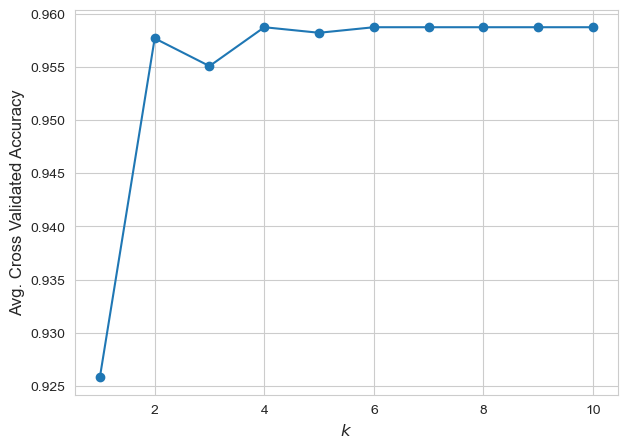

In [138]:
## Plots the accuracies as a function of k
plt.figure(figsize=(7,5))


plt.plot(ks, 
         np.mean(k_all_accs, axis=0),
         '-o')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. Cross Validated Accuracy", fontsize=12)

plt.show()

Seems the average accuracy converged to something...I'm worried that since the DST weekends represent such a small percentage of the total weekends, there's not much to see here. In fact, I'm guessing for more neighbors $k$, the model is simply learning to guess everything is a non-DST weekend and getting accuracy slightly below $0.96$. If we look at the proportions of non-DST to DST weekends for Wells Fargo, it is $0.958627$. So this may very well be the number that we're converging to above.

In [137]:
WFC['y'].value_counts(normalize=True) # see the proportion of each group

y
0    0.958627
1    0.041373
Name: proportion, dtype: float64